In [6]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm

In [7]:
config_file = '../models/carpart_aug/carpart.py'
checkpoint_file = '../models/carpart_aug/epoch_10.pth'

In [8]:
torch.cuda.set_device(1)

In [9]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:1')

2021-03-04 07:34:03,975 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.conv2.weight_diff, layer2.0.conv2.switch.weight, layer2.0.conv2.switch.bias, layer2.0.conv2.pre_context.weight, layer2.0.conv2.pre_context.bias, layer2.0.conv2.post_context.weight, layer2.0.conv2.post_context.bias, layer2.0.conv2.offset_s.weight, layer2.0.conv2.offset_s.bias, layer2.0.conv2.offset_l.weight, layer2.0.conv2.offset_l.bias, layer2.0.rfp_conv.weight, layer2.0.rfp_conv.bias, layer2.1.conv2.weight_diff, layer2.1.conv2.switch.weight, layer2.1.conv2.switch.bias, layer2.1.conv2.pre_context.weight, layer2.1.conv2.pre_context.bias, layer2.1.conv2.post_context.weight, layer2.1.conv2.post_context.bias, layer2.1.conv2.offset_s.weight, layer2.1.conv2.offset_s.bias, layer2.1.conv2.offset_l.weight, layer2.1.conv2.offset_l.bias, layer2.2.conv2.weight_diff, layer2.2.conv2.switch.weight, layer2

In [10]:
path = Path('../data/carpart_train')

In [11]:
test = json.load(open(path/'annotations'/'test.json'))
print(len(test['images']))

983


In [12]:
# test a single image
img = cv2.imread(str(path/'images'/test['images'][0]['file_name']))
result = inference_detector(model, img)

In [12]:
# show the results
img_,bboxs,segms,labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.7)

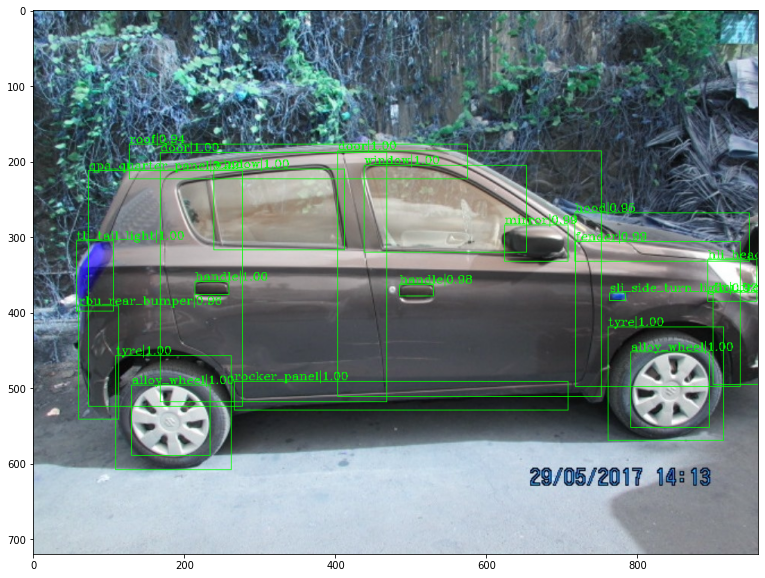

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(img_)

(720, 960)


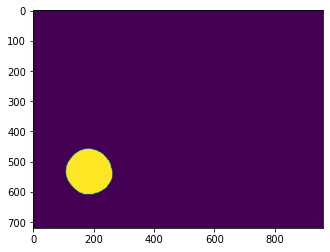

In [27]:
print(segms[0].shape)
plt.imshow(segms[2])

In [70]:
def cal_iou(img,box1,box2):
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal(img,pred_boxes,pred_labels,gt_boxes,gt_labels):
    tp = 0
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.5 :
                tp += 1
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_boxes[idx] = -1
                gt_labels[idx] = -1
                break
    
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 


In [14]:
total_tp ,total_fp,total_fn = 0,0,0
for i in test['images']:
    image = cv2.imread(str(path/'images'/i['file_name']))
    print(i['file_name'])
    
    gt_labels = [a['category_id']-1 for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]

    result = inference_detector(model, image)
    _,pred_boxs,_,pred_labels,_ = show_result_pyplot(model, image.copy(), result,score_thr=0.6)
    
    tp,fp,fn = cal(image,pred_boxs,pred_labels,gt_boxes,gt_labels)
    
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    print(tp,fp,fn)

print('sum tp :',total_tp,' fp :',total_fp,' fn : ',total_fn)
    

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_564_IMG_4152.JPG
23 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_31_DSCN0619.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131818076_img2067882.jpg
31 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_814_IMG_0956.JPG
24 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_237_IMG-20181001-WA0044.jpg
6 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_402_IMG_4584.jpg
7 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817755_img2058917.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8103.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1038_IMG_5176.jpg
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_528_IMG_7758.JPG
9 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_610_IMG-20171117-WA0072.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_2019040

2 0 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_608_TimePhoto_20180508_161016.jpg
7 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1225_IMG20190224_1314291600074058249924621.jpg
1 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_959_IMG_4481.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_773_IMG_4034.JPG
9 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1274_DSCN8492.JPG
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1500_DSCN5022.JPG
24 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_461_IMG_5359.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4723.JPG
27 3 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_745_IMG_5309.JPG
13 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_474_IMG_6847.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_717_IMG_4082.JPG
4 0 0
https:__s3.amazonaws.com_mc-ai_datase

11 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4094.JPG
20 1 8
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_293_IMG_7160MARK+(3).jpg
5 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_555_IMG_8937.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_200_IMG-20180919-WA0013.jpg
2 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511800967_img1738888.jpg
8 2 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801041_img1747104.jpg
30 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131905974_img2902345.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_934_IMG_20180629_135316.jpg
23 1 6
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511900745_img2815880.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_437_TimePhoto_20180505_141041.jpg
13 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_535_IMG_7740.JPG
9 1 1

6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1139_DSCN2064.JPG
10 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44010111919364_img3314548.jpg
22 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111826078_img2323560.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1494_DSCN4834.JPG
4 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_296_DSCN1133mark+(4).JPG
8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_814_IMG_0964.JPG
26 0 9
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_723_IMG_1290.JPG
9 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111829890_img2391176.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_454_IMG_0737.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_188_DSCN3096mark+(6).JPG
3 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_557_IMG_6593.JPG
15 1 5
https:__s3.amazonaws.com_mc-ai_dataset_i

18 1 12
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1067_DSCN3997mark+(5).JPG
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_668_IMG_9492.JPG
13 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_81_DSCN0118.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_52_IMG-20190402-WA0018.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_925_IMG_4525.JPG
23 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_885_IMG_8039.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1191_IMG_20181215_120115.jpg
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1232_IMG_20180809_143651.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_439_IMG_5540.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131818076_img2067894.jpg
12 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131906656_img2922623.jpg
11 0 0
https:__s3.amazonaws.com

11 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_719_IMG_5543.JPG
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_109_IMG_6668.JPG
2 0 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_673_DSCN7081.JPG
13 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_547_IMG_2989.JPG
11 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_882_IMG_0016.JPG
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_03_44011511801259_img1771097.jpg
23 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_599_IMG_4641.JPG
11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_569_IMG_4189.JPG
11 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1485_DSCN5667.JPG
2 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_966_IMG_8799.JPG
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_167_DSCN0774mark+(5).JPG
5 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_65_IMG_

11 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_298_IMG-20180315-WA0242.jpg
1 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1196_IMG-20190407-WA0044.jpg
11 2 7
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_471_IMG_2902.JPG
12 1 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906094_img2906196.jpg
11 2 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111835208_img2542647.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_02_44011511801041_img1747110.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1253_IMG_20170418_131444.jpg
4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901468_img2911172.jpg
3 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_771_DSCN0149.jpg
24 2 6
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1478_IMG_20181128_151754.jpg
17 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1200_DSCN6222.JPG
5 0 

16 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_468_IMG_2357.JPG
7 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_888_IMG_0589.JPG
33 1 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_545_IMG_7005.JPG
9 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_823_TimePhoto_20180503_134651.jpg
12 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_730_IMG_0633.JPG
12 0 4
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131826438_img2428008.jpg
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_814_IMG_0961.JPG
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_574_IMG_9850.JPG
13 3 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817886_img2439616.jpg
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_409_100_3476.JPG
17 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1042_IMG-20180806-WA0075.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_datas

2 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_592_IMG_6149.JPG
22 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901386_img2899417.jpg
21 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_918_IMG_9918.JPG
5 2 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_06_44012131906094_img2964034.jpg
6 1 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_543_IMG_8544.JPG
6 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1117_IMG_20180417_141644.jpg
15 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_920_IMG-20180717-WA0074.jpg
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_323_IMG-20190213-WA0055.jpg
10 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_743_IMG_3680.JPG
17 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_07_44012131907124_img2936504.jpg
6 0 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_854_IMG_0788.JPG
8 0 0
https:__s3.amazonaws.c

6 2 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_378_100_2036.JPG
14 0 3
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44011511901358_img2894621.jpg
21 0 2
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_05_44012131818577_img2229308.jpg
11 2 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_557_IMG_6590.JPG
21 0 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1161_DSCN0183.JPG
27 0 11
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_577_IMG_9876.JPG
4 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_509_IMG_4769.JPG
8 0 1
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_04_44012131817889_img2062274.jpg
7 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_233_IMG-20181110-WA0030.jpg
5 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1242_IMG-20170411-WA0032.jpg
4 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_545_IMG_7003.JPG
14 0 2
https:__s3.amazonaws.com_mc-ai_

26 1 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1257_IMG-20190308-WA0114.jpg
8 4 2
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_408_IMG_4726.JPG
23 2 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_392_100_5137.JPG
15 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_173_DSCN9345.JPG
12 0 3
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_892_IMG_8641.JPG
23 0 7
https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111830695_img2414955.jpg
26 9 4
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_699_IMG_5724.JPG
30 1 1
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0009.jpg
8 0 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_570_IMG_7899.JPG
22 2 5
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1220_IMG-20181026-WA0033.jpg
11 1 0
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_500_IMG_7859.JPG
12 2 5
https:__s3.amazonaws.com_mc-ai_datas

In [84]:
def plot(name):
    image = cv2.imread(str(path/'images'/name))
    i = [i for i in test['images'] if i['file_name']==name][0]
    gt_labels = [a['category_id']-1 for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    result = inference_detector(model, image.copy())
    image_out,pred_boxes,_,pred_labels,_ = show_result_pyplot(model, image.copy(), result,score_thr=0.6)
    
    pred_tp = [0 for i in pred_boxes]
    gt_tp = [0 for i in gt_boxes]
       
    orgin_boxes = gt_boxes.copy()
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(image,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.5 :
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_boxes[idx] = -1
                gt_labels[idx] = -1
                gt_tp[idx] = 1
                pred_tp[i] = 1
                break 
    for i in range(len(pred_tp)):
        if pred_tp[i]==0:
            image_out = cv2.rectangle(image_out,pred_boxes[i][0],pred_boxes[i][1],(255,0,0),2)
    
    for i in range(len(gt_tp)):
        if gt_tp[i]==1:
            image = cv2.rectangle(image,orgin_boxes[i][0],orgin_boxes[i][1],(0,255,0),2)
        else:
            image = cv2.rectangle(image,orgin_boxes[i][0],orgin_boxes[i][1],(255,0,0),2)
    
    out = np.hstack((image_out,image))
    plt.figure(figsize=(20,10))

    plt.imshow(out)

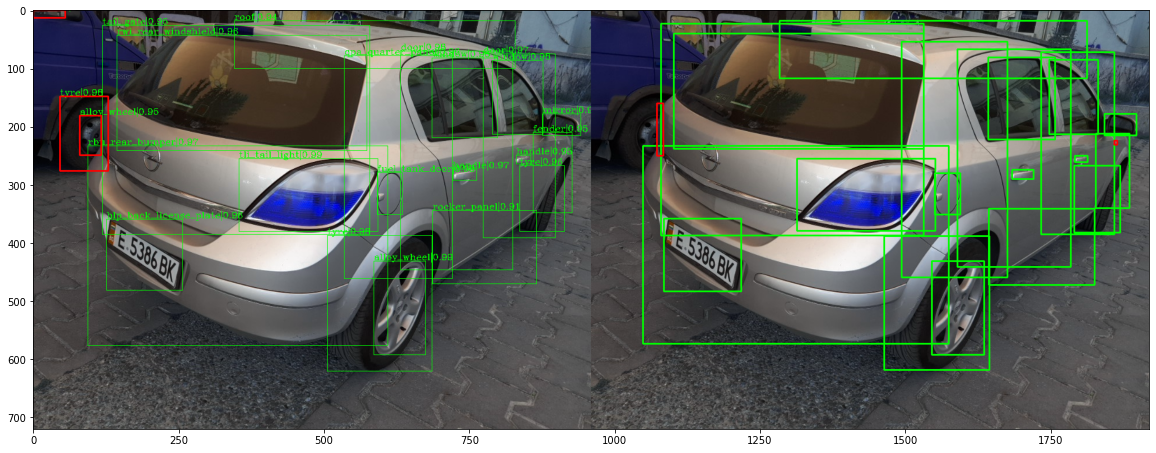

In [85]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_KRUG_unzipped_01_44010111830695_img2414954.jpg'
plot(name)

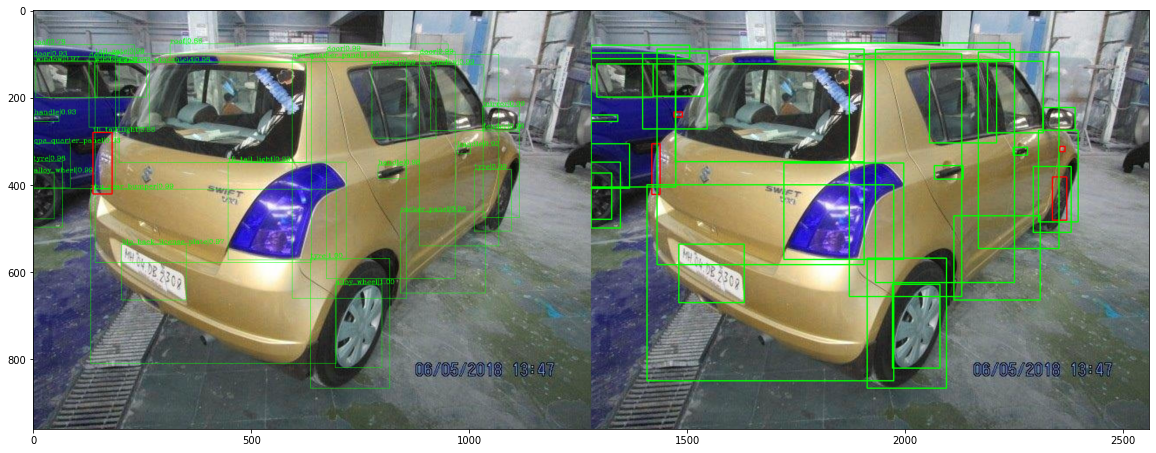

In [86]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_181_IMG_5703mark+(2).jpg'
plot(name)

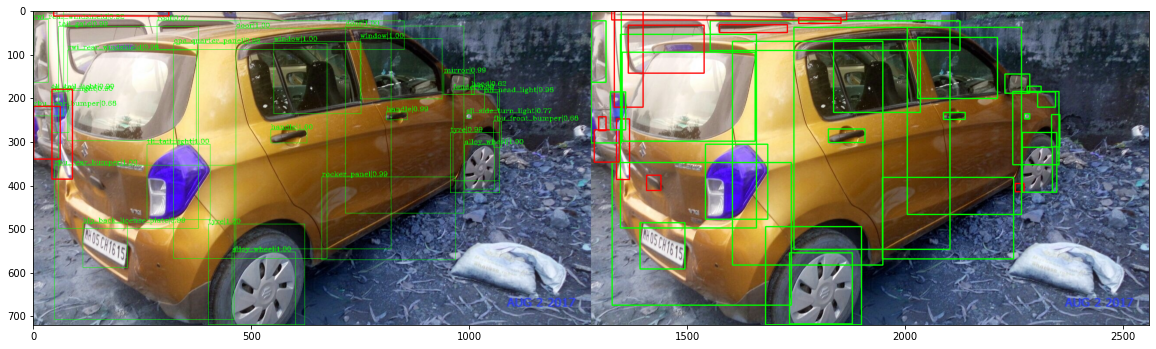

In [88]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_574_IMG_9853.JPG'
plot(name)

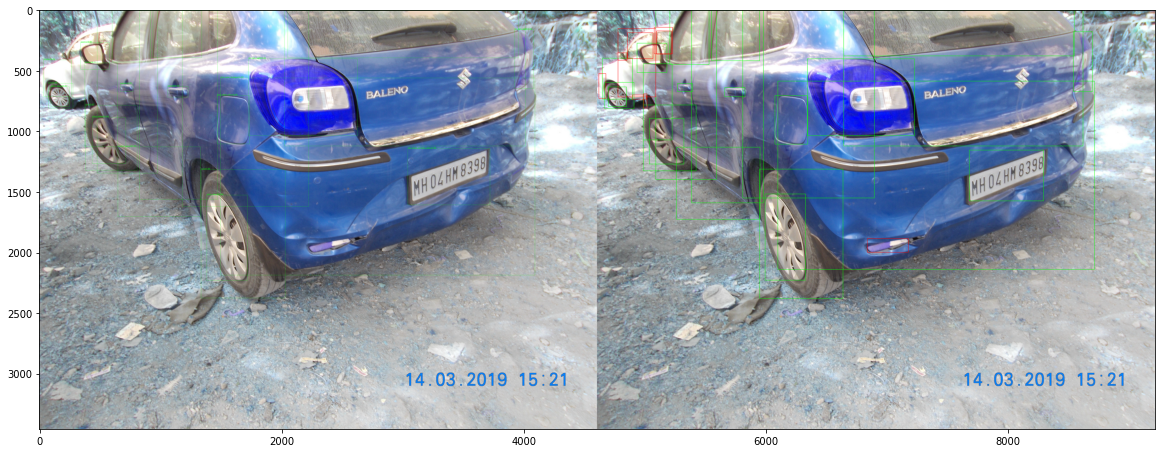

In [89]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_192_DSCN8517.JPG'
plot(name)

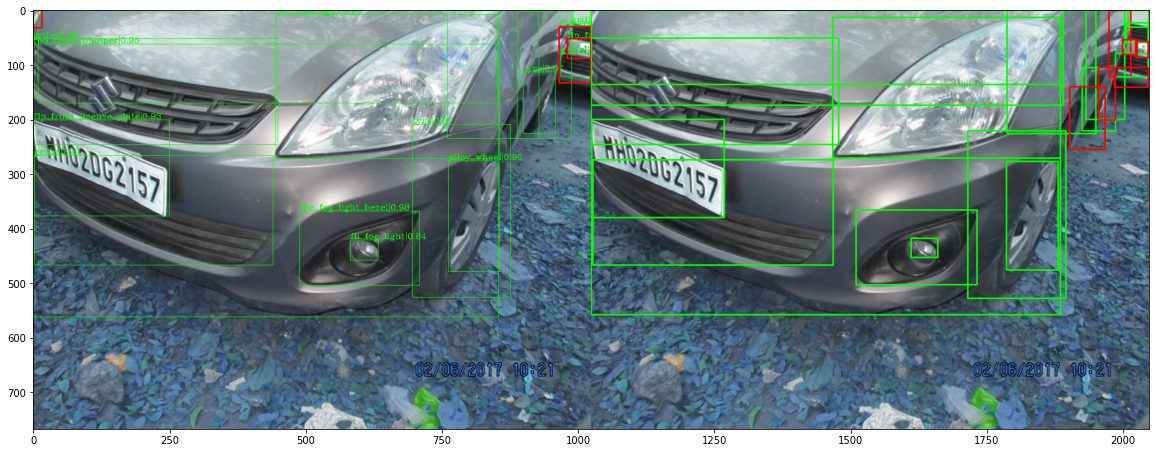

In [90]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_625_IMG_4345.JPG'
plot(name)

In [22]:
b = test['annotations'][0]['bbox']

In [26]:
print(b)
b1 = [(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))]
print(b1)

[441.99604743083, 822.1660013915051, 561.3438735177866, 256.12648221343863]
[(441, 822), (1002, 1078)]


In [16]:
box1 = [(109, 457), (262, 608)]
box2 =  [(209, 557), (362, 708)]

mask1 = np.zeros_like(img[:,:,0])
mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1

mask2 = np.zeros_like(img[:,:,0])
mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1

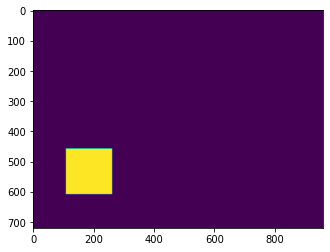

In [17]:
plt.imshow(mask1)

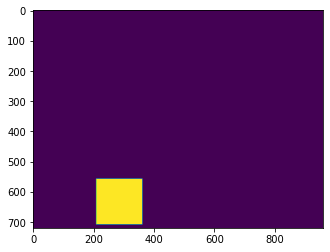

In [26]:
plt.imshow(mask2)

In [27]:
iou = np.logical_and(mask1,mask2)

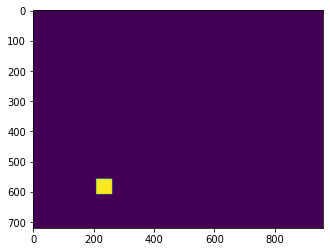

In [28]:
plt.imshow(iou)

In [30]:
a,b = 0,0
print(a,b)

0 0


In [31]:
a = [1,2,3,4,5]
b = ['a','b','c','d','e']

In [34]:
[i for (i,j) in zip(a,b) if j == 'e']

[5]

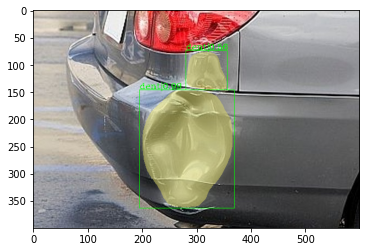

In [38]:
plt.imshow(cv2.cvtColor(out[0], cv2.COLOR_BGR2RGB))
plt.show()